# `如何使用機器學習提高房仲業潛在成交率_系列2_進階資料處理與基礎建模`
## 作者：陳政廷、王裕萍、謝豐檍(臺灣行銷研究特邀作者)、鍾皓軒(臺灣行銷研究有限公司創辦人）

## 原始資料請見[本連結](https://www.kaggle.com/c/two-sigma-connect-rental-listing-inquiries/data)，下載下來後與本ipynb檔案放於同一個工作目錄中，再執行下方程式即可

In [1]:
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import ADASYN
from sklearn.metrics import accuracy_score
import lightgbm as lgb
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

## 系列1_資料前處理

In [2]:
df_train=pd.read_json(open(r"train.json"))
#系列1_資料前處理
df_train["num_photos"]=df_train["photos"].apply(len)
df_train["num_description_words"]=df_train["description"].apply(lambda x:len(x.split(" "))) #根據空白切割，去算字數
def caculate(n_words):
    description_test=[]
    for i in n_words:
        description_test.append(len(i.split(" ")))
    return description_test #效果和上面一樣
df_train["created"]=pd.to_datetime(df_train["created"])
df_train["created_year"]=df_train["created"].dt.year
df_train["created_month"] = df_train["created"].dt.month
df_train["created_day"] = df_train["created"].dt.day

## 進階資料處理_特徵處理：篩選頻率大於100之字詞

In [3]:
bigdic = {}
for i in df_train['features']:
    for word in i:
        if word not in bigdic:
            bigdic[word] = 1
        else:
            bigdic[word] += 1
data = {'word': [*bigdic], 'number': [*bigdic.values()]}   
bigdf = pd.DataFrame.from_dict(data).sort_values(by='number', ascending=False)
keyword = bigdf[bigdf['number'] > 100]['word'].to_list()
print(keyword)
#
def get_dummy(keyword, alist):
    countlist = []
    for row in df_train['features']:
        if keyword in row:
            countlist.append(1)
        else:
            countlist.append(0)
    df_train[keyword] = countlist
for word in keyword:
    get_dummy(word, df_train['features'])
#
choose_columns=["bathrooms", "bedrooms", "latitude", "longitude","num_photos","price",'Elevator', 'Cats Allowed', 'Hardwood Floors', 'Dogs Allowed', 'Doorman', 'Dishwasher', 'No Fee', 'Laundry in Building', 'Fitness Center', 'Pre-War', 'Laundry in Unit', 'Roof Deck', 'Outdoor Space', 'Dining Room', 'High Speed Internet', 'Balcony', 'Swimming Pool', 'Laundry In Building', 'New Construction', 'Terrace', 'Exclusive', 'Loft', 'Garden/Patio', 'Wheelchair Access', 'Common Outdoor Space', 'HARDWOOD', 'Fireplace', 'SIMPLEX', 'prewar', 'LOWRISE', 'Garage', 'Laundry Room', 'Reduced Fee', 'Laundry In Unit', 'Furnished', 'Multi-Level', 'Private Outdoor Space', 'Prewar', 'PublicOutdoor', 'Parking Space', 'Roof-deck', 'dishwasher', 'High Ceilings', 'elevator', 'Renovated', 'Pool', 'LAUNDRY', 'Green Building', 'HIGH CEILINGS', 'LIVE IN SUPER', 'High Ceiling', 'Washer in Unit', 'Dryer in Unit', 'Storage', 'Stainless Steel Appliances', 'On-site laundry', 'Concierge', 'Newly renovated', 'On-site Laundry', 'Live In Super', 'Hardwood', 'Light', 'On-site Garage', 'Washer/Dryer', 'Granite Kitchen', 'Gym/Fitness', 'Pets on approval', 'Marble Bath', 'Walk in Closet(s)']

['Elevator', 'Cats Allowed', 'Hardwood Floors', 'Dogs Allowed', 'Doorman', 'Dishwasher', 'No Fee', 'Laundry in Building', 'Fitness Center', 'Pre-War', 'Laundry in Unit', 'Roof Deck', 'Outdoor Space', 'Dining Room', 'High Speed Internet', 'Balcony', 'Swimming Pool', 'Laundry In Building', 'New Construction', 'Terrace', 'Exclusive', 'Loft', 'Garden/Patio', 'Wheelchair Access', 'Common Outdoor Space', 'HARDWOOD', 'Fireplace', 'SIMPLEX', 'prewar', 'LOWRISE', 'Garage', 'Laundry Room', 'Reduced Fee', 'Laundry In Unit', 'Furnished', 'Multi-Level', 'Private Outdoor Space', 'Prewar', 'PublicOutdoor', 'Parking Space', 'Roof-deck', 'dishwasher', 'High Ceilings', 'elevator', 'Renovated', 'Pool', 'LAUNDRY', 'Green Building', 'HIGH CEILINGS', 'LIVE IN SUPER', 'High Ceiling', 'Washer in Unit', 'Dryer in Unit', 'Storage', 'Stainless Steel Appliances', 'On-site laundry', 'Concierge', 'Newly renovated', 'On-site Laundry', 'Live In Super', 'Hardwood', 'Light', 'On-site Garage', 'Washer/Dryer', 'Granite K

## 進階資料處理_特徵處理：特徵篩選、資料切分

In [4]:
#rf
X=df_train[choose_columns]
Y=df_train["interest_level"]
#
rf = RandomForestClassifier().fit(X,Y)		
for feature in zip(choose_columns, rf.feature_importances_):
    print((feature))

selector = SelectFromModel(rf,prefit = True,threshold=0.01)
print("Features selected by SelectFromModel: "
      f"{np.array(choose_columns)[selector.get_support()]}")
X = X[np.array(choose_columns)[selector.get_support()]]
#
X_train_rf, X_test_rf, Y_train_rf, Y_test_rf = train_test_split(X, Y, test_size=0.2, random_state = 0)

('bathrooms', 0.017942848022459806)
('bedrooms', 0.054895209148873324)
('latitude', 0.14578665658102583)
('longitude', 0.14699626257281556)
('num_photos', 0.11523327852076971)
('price', 0.21353644482403694)
('Elevator', 0.015020470568634054)
('Cats Allowed', 0.012640083410707551)
('Hardwood Floors', 0.016929232032033607)
('Dogs Allowed', 0.012189421488408616)
('Doorman', 0.012086179236404832)
('Dishwasher', 0.014549995025766455)
('No Fee', 0.021496924522745472)
('Laundry in Building', 0.01362692431814025)
('Fitness Center', 0.010511052209204855)
('Pre-War', 0.017399146588368053)
('Laundry in Unit', 0.013166817602206188)
('Roof Deck', 0.008758251888734763)
('Outdoor Space', 0.009666602375450091)
('Dining Room', 0.010613353710703604)
('High Speed Internet', 0.006689604382465291)
('Balcony', 0.007062148066695819)
('Swimming Pool', 0.005123348089675596)
('Laundry In Building', 0.009690831323226814)
('New Construction', 0.0054740644767632555)
('Terrace', 0.0056028574031249945)
('Exclusive',

In [5]:
#xgb
X=df_train[choose_columns]
Y=df_train["interest_level"]
#
xgb = xgb.XGBClassifier().fit(X,Y)		
for feature in zip(choose_columns, xgb.feature_importances_):
    print((feature))

selector = SelectFromModel(xgb,prefit = True,threshold=0.02)
print("Features selected by SelectFromModel: "
      f"{np.array(choose_columns)[selector.get_support()]}")
X = X[np.array(choose_columns)[selector.get_support()]]
#
X_train_xgb, X_test_xgb, Y_train_xgb, Y_test_xgb = train_test_split(X, Y, test_size=0.2, random_state = 0)

('bathrooms', 0.023299037)
('bedrooms', 0.05728956)
('latitude', 0.03170791)
('longitude', 0.025688747)
('num_photos', 0.06463715)
('price', 0.07509823)
('Elevator', 0.015026101)
('Cats Allowed', 0.0)
('Hardwood Floors', 0.13670494)
('Dogs Allowed', 0.015412761)
('Doorman', 0.009637335)
('Dishwasher', 0.030747833)
('No Fee', 0.09060067)
('Laundry in Building', 0.012489352)
('Fitness Center', 0.0062987907)
('Pre-War', 0.016118981)
('Laundry in Unit', 0.009111703)
('Roof Deck', 0.0016712534)
('Outdoor Space', 0.015450262)
('Dining Room', 0.011479532)
('High Speed Internet', 0.0)
('Balcony', 0.0022401984)
('Swimming Pool', 0.012119083)
('Laundry In Building', 0.04607277)
('New Construction', 0.0010066461)
('Terrace', 0.008725449)
('Exclusive', 0.024789108)
('Loft', 0.0039733807)
('Garden/Patio', 0.0025406785)
('Wheelchair Access', 0.0053706365)
('Common Outdoor Space', 0.0136557575)
('HARDWOOD', 0.072352126)
('Fireplace', 0.0028062335)
('SIMPLEX', 0.025450023)
('prewar', 0.0)
('LOWRISE', 

In [6]:
#lgb
X=df_train[choose_columns]
Y=df_train["interest_level"]
#
lgb = lgb.LGBMClassifier().fit(X,Y)	
for feature in zip(choose_columns, lgb.feature_importances_):
    print((feature))

selector = SelectFromModel(lgb,prefit = True,threshold=80)
print("Features selected by SelectFromModel: "
      f"{np.array(choose_columns)[selector.get_support()]}")
X = X[np.array(choose_columns)[selector.get_support()]]
#
X_train_lgb, X_test_lgb, Y_train_lgb, Y_test_lgb = train_test_split(X, Y, test_size=0.2, random_state = 0)

('bathrooms', 230)
('bedrooms', 806)
('latitude', 1655)
('longitude', 1456)
('num_photos', 602)
('price', 1824)
('Elevator', 95)
('Cats Allowed', 69)
('Hardwood Floors', 103)
('Dogs Allowed', 63)
('Doorman', 47)
('Dishwasher', 79)
('No Fee', 205)
('Laundry in Building', 90)
('Fitness Center', 55)
('Pre-War', 122)
('Laundry in Unit', 84)
('Roof Deck', 30)
('Outdoor Space', 65)
('Dining Room', 48)
('High Speed Internet', 33)
('Balcony', 63)
('Swimming Pool', 46)
('Laundry In Building', 125)
('New Construction', 34)
('Terrace', 52)
('Exclusive', 73)
('Loft', 36)
('Garden/Patio', 22)
('Wheelchair Access', 44)
('Common Outdoor Space', 27)
('HARDWOOD', 69)
('Fireplace', 16)
('SIMPLEX', 10)
('prewar', 6)
('LOWRISE', 3)
('Garage', 11)
('Laundry Room', 4)
('Reduced Fee', 78)
('Laundry In Unit', 60)
('Furnished', 114)
('Multi-Level', 15)
('Private Outdoor Space', 55)
('Prewar', 2)
('PublicOutdoor', 3)
('Parking Space', 28)
('Roof-deck', 5)
('dishwasher', 11)
('High Ceilings', 16)
('elevator', 19

## 進階資料處理_標準化

In [7]:
#rf
regression_col_rf = ["bathrooms", "bedrooms", "latitude", "longitude","num_photos","price"]
classification_col_rf = ['Elevator','Cats Allowed','Hardwood Floors','Dogs Allowed','Doorman','Dishwasher','No Fee','Laundry in Building','Pre-War','Laundry in Unit','Dining Room']
sc_rf = StandardScaler()
X_train_rf_r = sc_rf.fit_transform(X_train_rf[regression_col_rf])
X_test_rf_r = sc_rf.transform(X_test_rf[regression_col_rf])
X_train_rf_r = pd.DataFrame(X_train_rf_r).reset_index(drop=True)
X_test_rf_r = pd.DataFrame(X_test_rf_r).reset_index(drop=True)
X_train_rf_c = X_train_rf[classification_col_rf].reset_index(drop=True)
X_test_rf_c = X_test_rf[classification_col_rf].reset_index(drop=True)
X_train_rf = pd.concat([X_train_rf_r, X_train_rf_c],axis=1)
X_test_rf = pd.concat([X_test_rf_r, X_test_rf_c], axis = 1)
#xgb
regression_col_xgb = ["bathrooms", "bedrooms", "latitude", "longitude","num_photos","price"]
classification_col_xgb = ['Hardwood Floors','Dishwasher','No Fee','Laundry In Building','Exclusive','HARDWOOD','SIMPLEX','Reduced Fee','Furnished']
sc_xgb = StandardScaler()
X_train_xgb_r = sc_xgb.fit_transform(X_train_xgb[regression_col_xgb])
X_test_xgb_r = sc_xgb.transform(X_test_xgb[regression_col_xgb])
X_train_xgb_r = pd.DataFrame(X_train_xgb_r).reset_index(drop=True)
X_test_xgb_r = pd.DataFrame(X_test_xgb_r).reset_index(drop=True)
X_train_xgb_c = X_train_xgb[classification_col_xgb].reset_index(drop=True)
X_test_xgb_c = X_test_xgb[classification_col_xgb].reset_index(drop=True)
X_train_xgb = pd.concat([X_train_xgb_r, X_train_xgb_c],axis=1)
X_test_xgb = pd.concat([X_test_xgb_r, X_test_xgb_c], axis = 1)
#lgb
regression_col_lgb= ["bathrooms", "bedrooms", "latitude", "longitude","num_photos","price"]
classification_col_lgb = [ 'Elevator', 'Hardwood Floors', 'No Fee','Pre-War', 'Laundry In Building', 'Furnished']
sc_lgb = StandardScaler()
X_train_lgb_r = sc_lgb.fit_transform(X_train_lgb[regression_col_lgb])
X_test_lgb_r = sc_lgb.transform(X_test_lgb[regression_col_lgb])
X_train_lgb_r = pd.DataFrame(X_train_lgb_r).reset_index(drop=True)
X_test_lgb_r = pd.DataFrame(X_test_lgb_r).reset_index(drop=True)
X_train_lgb_c = X_train_lgb[classification_col_lgb].reset_index(drop=True)
X_test_lgb_c = X_test_lgb[classification_col_lgb].reset_index(drop=True)
X_train_lgb = pd.concat([X_train_lgb_r, X_train_lgb_c],axis=1)
X_test_lgb = pd.concat([X_test_lgb_r, X_test_lgb_c], axis = 1)

## 基礎建模

In [8]:
#rf
clf_rf= RandomForestClassifier(n_estimators=200,max_depth=13 ,random_state=0)
clf_rf.fit(X_train_rf, Y_train_rf)
print('Log loss on trainging_rf dataset: ',log_loss(Y_train_rf, clf_rf.predict_proba(X_train_rf)))
print('Log loss on testing_rf dataset: ',log_loss(Y_test_rf, clf_rf.predict_proba(X_test_rf)))
#xgb
import xgboost as xgb
clf_xgb= xgb.XGBClassifier(n_estimators=200,max_depth=4 ,random_state=0)
clf_xgb.fit(X_train_xgb, Y_train_xgb)
print('Log loss on trainging_xgb dataset: ',log_loss(Y_train_xgb, clf_xgb.predict_proba(X_train_xgb)))
print('Log loss on testing_xgb dataset: ',log_loss(Y_test_xgb, clf_xgb.predict_proba(X_test_xgb)))
#lgb
import lightgbm as lgb
clf_lgb= lgb.LGBMClassifier(random_state=0)
clf_lgb.fit(X_train_lgb, Y_train_lgb)
print('Log loss on trainging_lgb dataset: ',log_loss(Y_train_lgb, clf_lgb.predict_proba(X_train_lgb)))
print('Log loss on testing_lgb dataset: ',log_loss(Y_test_lgb, clf_lgb.predict_proba(X_test_lgb)))

Log loss on trainging_rf dataset:  0.505382112120454
Log loss on testing_rf dataset:  0.6272283213494952
Log loss on trainging_xgb dataset:  0.5731551036632873
Log loss on testing_xgb dataset:  0.6032119957024936
Log loss on trainging_lgb dataset:  0.5327268303907248
Log loss on testing_lgb dataset:  0.5934102373987091


## 預測成果

Text(0.5, 15.0, 'Predicted Value')

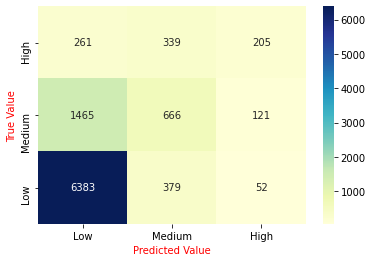

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(Y_test_lgb, clf_lgb.predict(X_test_lgb))
highhigh = cm[0][0]
highlow = cm[0][1]
highmedium = cm[0][2]
lowhigh = cm[1][0]
lowlow = cm[1][1]
lowmedium = cm[1][2]
mediumhigh = cm[2][0]
mediumlow = cm[2][1]
mediummedium = cm[2][2]
cm = [[highlow, highmedium, highhigh], [mediumlow, mediummedium, mediumhigh], [lowlow, lowmedium, lowhigh]]

cm_matrix = pd.DataFrame(data=cm, columns=['Low', 'Medium', 'High'], 
                                 index=['High', 'Medium', 'Low'])
sns.heatmap(cm_matrix, annot=True, fmt='d',cmap='YlGnBu')
plt.ylabel("True Value", color = 'r')
plt.xlabel("Predicted Value", color = 'r')

## 未使用特徵篩選的結果

In [36]:
choose_columns=["bathrooms", "bedrooms", "latitude", "longitude","num_photos","price",'Elevator', 'Cats Allowed', 'Hardwood Floors', 'Dogs Allowed', 'Doorman', 'Dishwasher', 'No Fee', 'Laundry in Building', 'Fitness Center', 'Pre-War', 'Laundry in Unit', 'Roof Deck', 'Outdoor Space', 'Dining Room', 'High Speed Internet', 'Balcony', 'Swimming Pool', 'Laundry In Building', 'New Construction', 'Terrace', 'Exclusive', 'Loft', 'Garden/Patio', 'Wheelchair Access', 'Common Outdoor Space', 'HARDWOOD', 'Fireplace', 'SIMPLEX', 'prewar', 'LOWRISE', 'Garage', 'Laundry Room', 'Reduced Fee', 'Laundry In Unit', 'Furnished', 'Multi-Level', 'Private Outdoor Space', 'Prewar', 'PublicOutdoor', 'Parking Space', 'Roof-deck', 'dishwasher', 'High Ceilings', 'elevator', 'Renovated', 'Pool', 'LAUNDRY', 'Green Building', 'HIGH CEILINGS', 'LIVE IN SUPER', 'High Ceiling', 'Washer in Unit', 'Dryer in Unit', 'Storage', 'Stainless Steel Appliances', 'On-site laundry', 'Concierge', 'Newly renovated', 'On-site Laundry', 'Live In Super', 'Hardwood', 'Light', 'On-site Garage', 'Washer/Dryer', 'Granite Kitchen', 'Gym/Fitness', 'Pets on approval', 'Marble Bath', 'Walk in Closet(s)']
X=df_train[choose_columns]
Y=df_train["interest_level"]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state = 0)
#rf
clf_bas_rf= RandomForestClassifier(n_estimators=200,max_depth=13 ,random_state=0)
clf_bas_rf.fit(X_train, Y_train)
print('Log loss on trainging_rf dataset: ',log_loss(Y_train, clf_bas_rf.predict_proba(X_train)))
print('Log loss on testing_rf dataset: ',log_loss(Y_test, clf_bas_rf.predict_proba(X_test)))
#xgb
import xgboost as xgb
clf_bas_xgb= xgb.XGBClassifier(n_estimators=200,max_depth=4 ,random_state=0)
clf_bas_xgb.fit(X_train, Y_train)
print('Log loss on trainging_xgb dataset: ',log_loss(Y_train, clf_bas_xgb.predict_proba(X_train)))
print('Log loss on testing_xgb dataset: ',log_loss(Y_test, clf_bas_xgb.predict_proba(X_test)))
#lgb
import lightgbm as lgb
clf_bas_lgb= lgb.LGBMClassifier(random_state=0)
clf_bas_lgb.fit(X_train, Y_train)
print('Log loss on trainging_lgb dataset: ',log_loss(Y_train, clf_bas_lgb.predict_proba(X_train)))
print('Log loss on testing_lgb dataset: ',log_loss(Y_test, clf_bas_lgb.predict_proba(X_test)))

Log loss on trainging_rf dataset:  0.5899987096527264
Log loss on testing_rf dataset:  0.6535922737341313
Log loss on trainging_xgb dataset:  0.5654956271061841
Log loss on testing_xgb dataset:  0.5980582246898305
Log loss on trainging_lgb dataset:  0.5192399472691339
Log loss on testing_lgb dataset:  0.5837578693471405


## 查看原始資料是否產生資料不平衡的狀況

High: 3034
Medium: 8977
Low: 27470


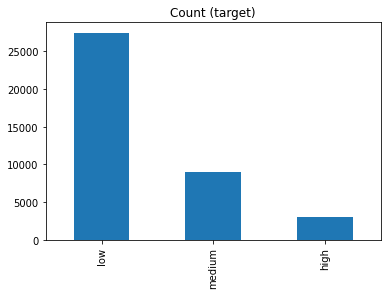

In [37]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state = 0)
df_train = pd.concat([X_train, Y_train], axis = 1)
df_valid = pd.concat([X_test, Y_test], axis = 1)
#
high = df_train[df_train["interest_level"] == 'high']
medium = df_train[df_train["interest_level"] == 'medium']
low = df_train[df_train["interest_level"] == 'low']
#
target_count = df_train.interest_level.value_counts()
print('High:', target_count['high'])
print('Medium:', target_count['medium'])
print('Low:', target_count['low'])

target_count.plot(kind='bar', title='Count (target)');